# Midterm November 19, 2021

In [58]:
import sympy
import math
from IPython.display import display, Math
from robotic.manipulator import JointType, Manipulator
from robotic import scalar_repr_latex
from robotic.utils import draw_frame
from robotic.transformations import (
    Axis,
    EulerOrder,
    EulerSequence,
    EulerSpec,
    HomogeneousTransformation,
    Rotation,
    Translation,
    X,
    Y,
    Z,
)

## Exercise 1

We are asked to find the final orientation of the body, after two sequential rotations. The first rotation must be applied to an axis $\bold{r}$ and the other around a fixed axis $y$.

Since the second rotation is around a fixed axis, not body-fixed axis, the rotation must be applied to the left of trhe first rotation.

In [59]:
r = Axis(
    sympy.sympify(1) / sympy.sqrt(3),
    sympy.sympify(1) / sympy.sqrt(3),
    sympy.sympify(1) / sympy.sqrt(3),
)
theta = sympy.pi / 3
phi = -sympy.pi / 3
r = Rotation.from_axis_angle((Y, phi)) @ Rotation.from_axis_angle((r, theta))
r.evalf().round()

Matrix([
[ 0.622, -0.744,  -0.244],
[0.6667, 0.6667, -0.3333],
[0.4107, 0.0447,  0.9107]])

## Exercise 2

The goal is to find the two sequences of ZYZ Euler angles that represent the transformation $R_{if}$, which define the transformation from $R_i$ to $R_f$.

Knowing that

$$
R_f = R_i R_{if}
$$

using the orthogonality of the matrices, we get:

$$
R_{if} = R_i^T R_f
$$

In [60]:
r_i = Rotation(
    sympy.Matrix(
        [
            [0, 0.5, -sympy.sqrt(3) / sympy.sympify(2)],
            [-1, 0, 0],
            [0, sympy.sqrt(3) / sympy.sympify(2), 0.5],
        ]
    )
)
r_f = Rotation.identity()
r_if = r_i.T @ r_f
r_if

Matrix([
[         0, -1,         0],
[       0.5,  0, sqrt(3)/2],
[-sqrt(3)/2,  0,       0.5]])

From which we need to extract the euler angles:

In [61]:
euler_spec = r_if.to_euler(EulerSequence.ZYZ, EulerOrder.FIXED)
if isinstance(euler_spec, tuple):
    display(Math(f"{euler_spec[0].euler_angles._repr_latex_()}"))
    display(Math(f"{euler_spec[1].euler_angles._repr_latex_()}"))

INFO | Starting Euler angle extraction with euler sequence ZYZ and euler order FIXED
INFO | Computing theta2 = atan2(sqrt(-0.8660^2 + 0^2), 0.5000)
INFO | Computing theta2_bis as -theta2
INFO | Computing theta1 = atan2(0.8660 / sin(theta2), 0 / sin(theta2))
INFO | Computing theta3 = atan2(0 / sin(theta2), 0.8660 / sin(theta2))
INFO | Computing alternative theta1_bis = atan2(0.8660 / sin(theta2_bis), 0 / sin(theta2_bis))
INFO | Computing alternative theta3_bis = atan2(0 / sin(theta2_bis), 0.8660 / sin(theta2_bis))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Exercise 3

TODO: Ask professor what I'm doing wrong.

We are tasked to complete the DH frames and get the associated table of parameters.
The first thing that need to be done when dealing with DH is assign the frames.

For assigning the D-H frames properly, the following conventions must be respected:

- $z_0$ must be aligned with the first joint axis (rotation or translation).
- $x_0$ is arbitrary (it can be chosen freely) as long as it:
    - Is orthogonal to $z_0$
    - Follows the D-H convention for defining distances and angles.
- $y_0$ must complete a right handed frame with $x_0$ and $z_0$.

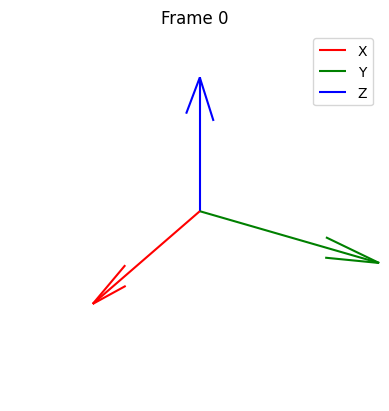

In [62]:
r_0 = Rotation.identity()
frame_0 = draw_frame(
    r_0, label="Frame 0", basis=Rotation.from_axis_angle((Z, -sympy.pi / 2))
)

Now the assignation of the remaing frames is straight forward (except for the last frame).
We have to follow these simple rules:

- The $z_i$ axis must be aligned with the axis of motion of Joint $i+1$
- The $x_i$ axis must:
    - Be perpendicular to both $z_i$ and $z_{i-1}$
    - Lie along the commond normal   

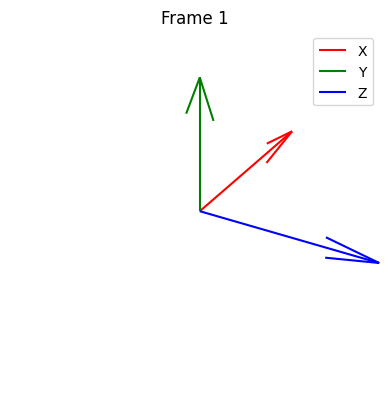

In [63]:
# TODO: Ask de luca, I haven't been able to find a rotation that has no Z component,
# so why the dh table doesn't have a pi term?
r_1 = Rotation.from_axis_angle((Z, sympy.pi)) @ Rotation.from_axis_angle(
    (X, sympy.pi / 2)
) 
frame_1 = draw_frame(rotation=r_1, label="Frame 1", basis=frame_0)


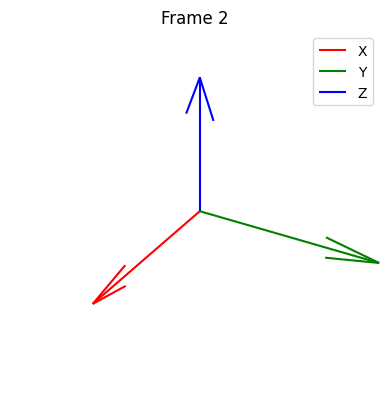

In [64]:
# TODO: Ask De luca how he got + pi/2
r_2 = Rotation.from_axis_angle((Y, sympy.pi)) @ Rotation.from_axis_angle(
     (X, -sympy.pi / 2)
)
frame_2 = draw_frame(rotation=r_2, label="Frame 2", basis=frame_1)

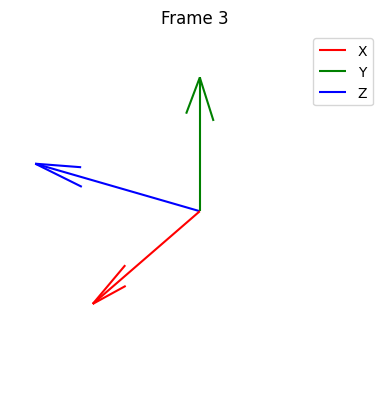

In [65]:
r_3 = Rotation.from_axis_angle((X, sympy.pi / 2))
frame_3 = draw_frame(rotation=r_3, label="Frame 3", basis=frame_2)

For the last link:

- If the $n$-th joint is revolute the last axis must be aligned with the direction of $z_{n-1}$
- The position of $x_n$ along $z_{n-1}$ is arbitraty if no link lenght or offset is specified

In this problem however another thing is subtly required:

>  If needed, provide the transformation between the last D-H frame and the standard frame of an end-effector gripper.

The standard frame for a gripper usually follows these rules

- The $z$ axis directed in the approach direction of the gripper
- The $y$ axis directed in the slide direction of the gripper

In this case the D-H frame assignment for the last link is not compatible with the desired standard end-effector frame.
In particular the incopatibility comes from the fact that it must be $z_4 \neq z_e$ 


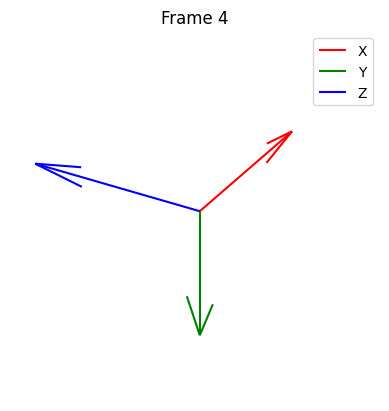

In [66]:
r_4 = Rotation.from_axis_angle((Z, sympy.pi))
frame_4 = draw_frame(rotation=r_4, label="Frame 4", basis=frame_3)


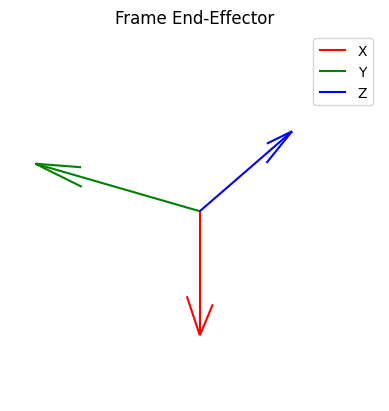

In [67]:
r_ee = Rotation.from_axis_angle((Y, sympy.pi / 2)) @ Rotation.from_axis_angle(
    (Z, sympy.pi / 2)
)
frame_ee = draw_frame(rotation=r_ee, label="Frame End-Effector", basis=frame_4)

Once we defined the needed frames, we can proceed to compute the DH table.
Where $a_4 \neq 0$ because when two frames have the same $z$ axis the $a$ parameter is the distance between them.

In [68]:

man = Manipulator(
    [JointType.REVOLUTE, JointType.REVOLUTE, JointType.REVOLUTE, JointType.REVOLUTE],
    [sympy.pi / 2, -sympy.pi / 2, -sympy.pi / 2, 0],
    [0, 0, 0, 0],
    [sympy.pi, 0, 0, 0], 
    [sympy.symbols("d_1"), 0, sympy.symbols("d_3"), 0], # Distance along the z axis
)
man.dh_table()

   a \alpha    d    \theta      type
0  0   pi/2  d_1  q_1 + pi  REVOLUTE
1  0  -pi/2    0       q_2  REVOLUTE
2  0  -pi/2  d_3       q_3  REVOLUTE
3  0      0    0       q_4  REVOLUTE

## Exercise 4 

Drawing, the general idea is to get the cartesian product of all possible limits and picture them in your head.
From the drawing the requested point P should lie in the primary workspace and thus be reachable by the end effector.

## Excercise 5

We are going to assign the dh parameters to the left branch



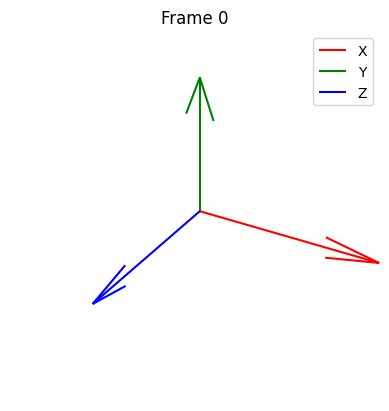

In [69]:
r_0 = Rotation.identity()
frame_0 = draw_frame(r_0, label="Frame 0")

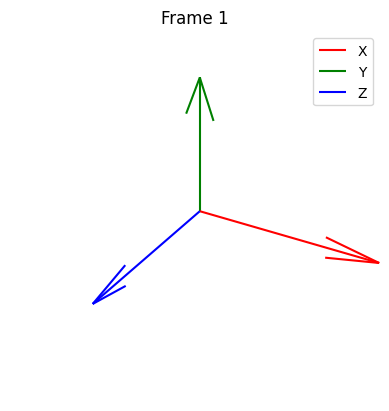

In [70]:
r_1 = Rotation.identity()
frame_1 = draw_frame(r_1, label="Frame 1")

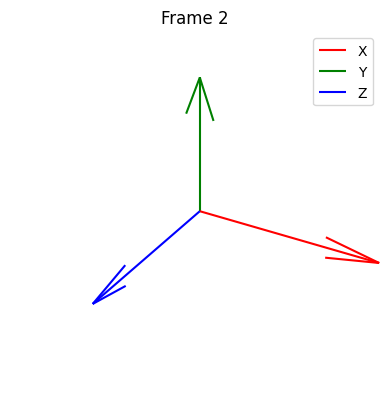

In [71]:
r_2 = Rotation.identity()
frame_2 = draw_frame(r_2, label="Frame 2", basis=frame_1)

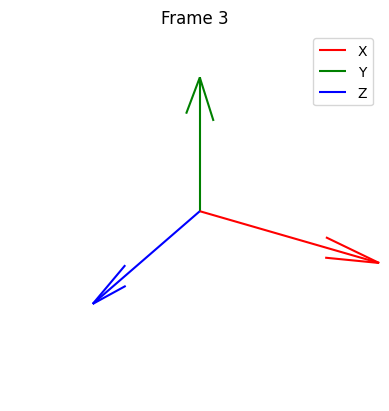

In [72]:
r_3 = Rotation.identity()
frame_3 = draw_frame(r_3, label="Frame 3", basis=frame_2)

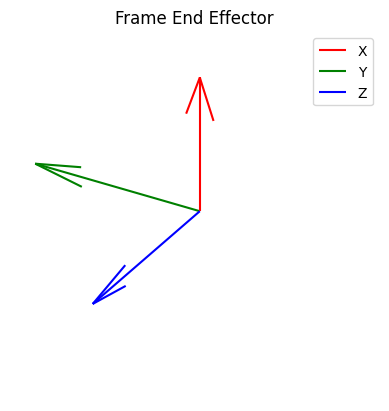

In [73]:
r_ee = Rotation.from_axis_angle((Z, sympy.pi / 2))
frame_ee = draw_frame(r_ee, label="Frame End Effector", basis=frame_3)

In [74]:
man_r = Manipulator(
    [JointType.REVOLUTE, JointType.REVOLUTE, JointType.REVOLUTE],
    [0,0,0],
    [sympy.symbols("L_0"),sympy.symbols("L_{r1}"),sympy.symbols("L_{r2}")],
    # TODO: Ask Deluca.
    # I would have combined frame 3 with frame End effector, I guess he just added a new rotation for the end effector, but why  ? 
    [0,0,0], # Try to
    [0,0,0],
    
    )
man_r.dh_table()

        a \alpha  d \theta      type
0     L_0      0  0    q_1  REVOLUTE
1  L_{r1}      0  0    q_2  REVOLUTE
2  L_{r2}      0  0    q_3  REVOLUTE

In [75]:
sympy.simplify(man_r.dh_matrix() @ r_ee)

WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skip

Matrix([
[-sin(q_1 + q_2 + q_3), -cos(q_1 + q_2 + q_3), 0, L_0*cos(q_1) + L_{r1}*cos(q_1 + q_2) + L_{r2}*cos(q_1 + q_2 + q_3)],
[ cos(q_1 + q_2 + q_3), -sin(q_1 + q_2 + q_3), 0, L_0*sin(q_1) + L_{r1}*sin(q_1 + q_2) + L_{r2}*sin(q_1 + q_2 + q_3)],
[                    0,                     0, 1,                                                                  0],
[                    0,                     0, 0,                                                                  1]])

In [76]:
man_r.dh_matrix().as_translation()

WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skipping numeric validation: matrix is symbolic
WARNING | Skip

Matrix([
[L_0*cos(q_1) + L_{r1}*cos(q_1 + q_2) + L_{r2}*cos(q_1 + q_2 + q_3)],
[L_0*sin(q_1) + L_{r1}*sin(q_1 + q_2) + L_{r2}*sin(q_1 + q_2 + q_3)],
[                                                                 0]])

## Excercise 6

First we need to solve this system of equations:

$$
p_x = l_1 cos(q_1) + q_3 cos(q_1+q_2) \\
p_y = l_1 sin(q_1) + q_3 sin(q_1+q_2) \\
\alpha = q_1+ q_2 \\
$$

Where $p_x, p_y$ and $\alpha$ are known.
We need to try isolate each term as much as possible, the first thing we can do is substitue $q_1+q_2$ with alpha, leading to:

$$
p_x = l_1 cos(q_1) + q_3 cos(\alpha) \\
p_y = l_1 sin(q_1) + q_3 sin(\alpha) \\
$$

Now we still have a dependence on both $q_1$ and $q_3$, however knowing that $cos^2 + sin^2 = 1$ we can move $q_3 cos(\alpha)$ and $q_3 sin(\alpha)$ to the left side:

$$
p_x - q_3 cos(\alpha)= l_1 cos(q_1) \\
p_y - q_3 sin(\alpha)= l_1 sin(q_1) \\
$$

We can now remove the dependence of $q_1$ by summing and squaring both equations:

$$
(p_x - q_3 cos(\alpha))^2 + (p_y - q_3 sin(\alpha))^2 = l_1^2 (cos(q_1) + sin(q_1) ) = l_1 ^2
$$

Where

$$
(p_x - q_3 cos(\alpha))^2 + (p_y - q_3 sin(\alpha))^2 = q_3^2 + p_x^2 + p_y^2 - 2q_3(p_x cos(\alpha) + p_y sin(\alpha)) =  l_1 ^2
$$

Moving $l_1 ^2$ to the left side, we have a linear equation with the only unknown $q_3$:

$$
q_3^2 + p_x^2 + p_y^2 - 2q_3(p_x cos(\alpha) + p_y sin(\alpha)) - l_1 ^2 = 0
$$

Rearranging terms we got

$$
q_3^2  - 2 q_3(p_x cos(\alpha) + p_y sin(\alpha)) + ( p_x^2 + p_y^2 -l_1 ^2) = 0
$$

Which is a second order equation, in the form 

$$
ax^2 + bx +c = 0
$$

Which has a **real** solution if and only if

$$
b^2 - 4ac \geq 0
$$

Which in our case equates to

$$
4 (p_x cos(\alpha) + p_y sin(\alpha)) ^2 - 4 (p_x^2 + p_y^2 -l_1 ^2) \geq 0 \rightarrow (p_x cos(\alpha) + p_y sin(\alpha)) ^2 - (p_x^2 + p_y^2 -l_1 ^2) \geq 0
$$

Which can be rewritten as:

$$
p_x^2 cos(\alpha)^2 + p_y^2 sin(\alpha)^2 + 2p_xp_y cos(\alpha)sin(\alpha) - p_x^2 - p_y^2 + l_1^2  = p_x^2(cos(\alpha)^2 - 1) + p_y^2(sin(\alpha)^2 - 1) + l_1^2 + 2p_xp_y cos(\alpha)sin(\alpha)
$$

By using the Product to Sum formulas and pythagorean identities

$$
sin(\alpha)^2 + cos(\alpha)^2 = 1 \rightarrow  - sin(alpha)^2 = cos(\alpha)^2 - 1 \\
sin(\alpha)^2 + cos(\alpha)^2 = 1 \rightarrow  - cos(alpha)^2 = sin(\alpha)^2 - 1 \\
sin(\alpha) cos(\alpha) = \frac{1}{2} sin(2\alpha)
$$

We can rewrite finally

$$
l_1^2 - p_x^2 sin(\alpha)^2 - p_x^2 cos(\alpha)^2 + p_x p_y sin(2\alpha)
$$

We can distinguish the situations in:

- $\Delta > 0$ regular solution, the robot has two configurations for the same position
- $\Delta = 0$ we have only one solution, thus a singularity, the robot loses a degree of freedom
- $\Delta < 0$ the target is not reachable

Since we have to discard the first two cases as per problem request, we can determine the value of $q_3, q_2, q_1$

$$
q_3^{\pm} = p_x cos(\alpha) + p_y sin(\alpha) \pm \sqrt{\Delta}
$$

Rembering that 


$$
p_x = l_1 cos(q_1) + q_3^{\pm} cos(\alpha) \rightarrow p_x - q_3^{\pm} cos(\alpha) = l_1 cos(q_1) \\
p_y = l_1 sin(q_1) + q_3^{\pm} sin(\alpha) \rightarrow p_y - q_3^{\pm} sin(\alpha) = l_1 sin(q_1) \\
$$

Thus

$$
\frac{sin(q_1)}{cos(q_1)}= \frac{p_y - q_3^{\pm} sin(\alpha)}{p_x - q_3^{\pm} cos(\alpha)} \rightarrow q_1 = atan_2( p_y - q_3^{\pm} sin(\alpha), p_x - q_3^{\pm} cos(\alpha))
$$

Finally

$$
q_2^{\pm} = \alpha - q_1^{\pm}
$$

In [105]:
l_1,q_1,q_2 ,q_3, p_x,p_y, alpha, sign= sympy.symbols("l_1,q_1,q_2,q_3,p_x,p_y,alpha,sign")

q_3 = p_x * sympy.cos(alpha) + p_y * sympy.sin(alpha) + sign * sympy.sqrt(l_1**2 - (p_x* sympy.sin(alpha))**2 - (p_y * sympy.cos(alpha))**2 + (p_x * p_y * sympy.sin(2*alpha)))
q_1 = sympy.atan2(p_y - q_3*sympy.sin(alpha),p_x - q_3 * sympy.cos(alpha), )
q_2 = alpha - q_1

numerical_values = {"l_1": 1, "p_x": 2 , "p_y": 1, "alpha": sympy.pi/6}
numerical_q_3 = q_3.subs(numerical_values)
numerical_values.update({"q_3":numerical_q_3})
numerical_q_2 = q_2.subs(numerical_values)
numerical_values.update({"q_2":numerical_q_2})
numerical_q_1 = q_1.subs(numerical_values)

display(Math("q_1^{+} = " + f"{numerical_q_1.subs("sign",1).evalf():.4f}"))
display(Math("q_2^{+} = " + f"{numerical_q_2.subs("sign",1).evalf():.4f}"))
display(Math("q_3^{+} = " + f"{numerical_q_3.subs("sign",1).evalf():.4f}"))

display(Math("q_1^{-} = " + f"{numerical_q_1.subs("sign",-1).evalf():.4f}"))
display(Math("q_2^{-} = " + f"{numerical_q_2.subs("sign",-1).evalf():.4f}"))
display(Math("q_3^{-} = " + f"{numerical_q_3.subs("sign",-1).evalf():.4f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Excercise 7

We need to find the motor torque $\tau_m$ that produces the desired angular acceleration, under the conditions that only $J_l$ s known and the system operates under an optimal intertia matching.

$$
\tau_m = J_m \ddot{\theta}_m + \frac{1}{n}(J_l \ddot{\theta}_l)
$$
- $J_m$ is the inertia of the motor
- $\ddot{\theta}_m$ is the angular acceleration of the motor
- $n$ is the gear reduction ratio
- $J_l$ is the link inertia
- $\ddot{\theta}_l$ is the link angular acceleration

First, the gear ratio is determined by the relationship between the motor and the link angular velocity
$$
\begin{aligned}
r_m \dot{\theta}_m = r_l \dot{\theta}_l \\
\dot{\theta}_m = n \dot{\theta}_l
\end{aligned}
\implies 
n = \frac{r_l}{r_m}
$$

Differentiating $\dot{\theta}_m = n \dot{\theta}_l$ w.r.t time, is also true that

$$
\ddot{\theta}_m = n \ddot{\theta}_l
$$

In the optimal inertia matching condition, $n$ must satisfy this requirement:
$$
n = \sqrt{\frac{J_l}{J_m}} \implies J_m = \frac{J_l}{n^2} 
$$

Thus, since everything is known, we can rewrite the initial expression as:

$$
\tau_m = J_m n \ddot{\theta}_l + \frac{1}{n}(J_l \ddot{\theta}_l) = \ddot{\theta}_l \frac{2J_l }{n}
$$

In [ ]:
r_m = 2
r_l = 10
n = r_l / r_m
j_l = .3
theta_dot_dot_l = -5
display(Math(r"\tau_m = " + f"{theta_dot_dot_l * ((2 * j_l) / n)}"))


<IPython.core.display.Math object>

# Excercise 8

TODO: Ask de luca, where this formula comes from

We ned to find the minimum number traks $n_t$ such that with the given link length $L$ we have a maximum error of no more than $\delta$.

We know that the arc lenght $s$ is given by
